In [2]:
import sys
# CausalML is not supported for Pyhon 2.7
if sys.version_info < (3, 0):
    exit(0)

# Uplift random forest modeling - H2O-3 vs. CausalML

In [3]:
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score

import h2o
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

import pandas as pd
from IPython.display import Image

In [4]:
control_name = "control"
treatment_column = "treatment"
response_column = "outcome"
feature_cols = ["feature_"+str(x) for x in range(1,13)]

train_df = pd.read_csv("../../smalldata/uplift/upliftml_train.csv")
test_df = pd.read_csv("../../smalldata/uplift/upliftml_test.csv")

train_df[treatment_column].replace({1: "treatment", 0: "control"}, inplace=True)
test_df[treatment_column].replace({1: "treatment", 0: "control"}, inplace=True)
train_df.shape, test_df.shape

((4989, 17), (5011, 17))

In [5]:
ntree = 40
max_depth = 10
metric_cml="EU"
metric_h2o="Euclidean"

# CausalML

In [6]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction=metric_cml,
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=0,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(train_df[feature_cols].values,
                 treatment=train_df[treatment_column].values,
                 y=train_df[response_column].values)

#test_df = train_df
causalml_preds = causalml_uplift_model.predict(test_df.drop("treatment", axis=1).values)

# H2O-3

In [7]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,6 mins 57 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,6 days
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.877 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [8]:
train_h2o = h2o.H2OFrame(train_df)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            treatment_column=treatment_column,
            uplift_metric=metric_h2o,
            min_rows=10,
            auuc_nbins=100,
            seed=42,
            sample_rate=0.50,
            auuc_type="gain",
            score_each_iteration=False)
h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=train_h2o)
h2o_uplift_model

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1649756637843_62


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,40.0,80.0,24305.0,9.0,9.0,9.0,11.0,29.0,19.625




ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 438.91621787270583
AUUC normalized: 1.0243607039739482

AUUC table (number of bins: 100): All types of AUUC value


,uplift_type,qini,lift,gain
0,AUUC value,220.031802,0.219001,438.916218
1,AUUC normalized,1.021918,0.219001,1.024361
2,AUUC random value,108.711176,0.043363,216.338275


Qini value: 111.3206265315211

AECU values table: All types of AECU value


,uplift_type,qini,lift,gain
0,AECU value,111.320627,0.175638,222.577943



Scoring History: 


,,timestamp,duration,number_of_trees,training_auuc_nbins,training_auuc,training_auuc_normalized,training_qini_value
0,,2022-04-12 11:50:56,0.044 sec,0.0,0,NaN,NaN,NaN
1,,2022-04-12 11:50:56,0.071 sec,1.0,15,366.755916,0.855950,43.835470
2,,2022-04-12 11:50:56,0.086 sec,2.0,40,395.012929,0.921897,80.325497
3,,2022-04-12 11:50:56,0.101 sec,3.0,59,408.367429,0.953065,93.433475
4,,2022-04-12 11:50:56,0.127 sec,4.0,78,389.270971,0.908497,84.215633
5,,2022-04-12 11:50:56,0.146 sec,5.0,94,400.061840,0.933681,90.757261
6,,2022-04-12 11:50:56,0.177 sec,6.0,99,418.919837,0.977692,101.321117
7,,2022-04-12 11:50:56,0.216 sec,7.0,100,421.546681,0.983823,102.566550
8,,2022-04-12 11:50:56,0.267 sec,8.0,100,423.997945,0.989544,103.645982
9,,2022-04-12 11:50:56,0.306 sec,9.0,100,427.692317,0.998166,105.195268



See the whole table with table.as_data_frame()


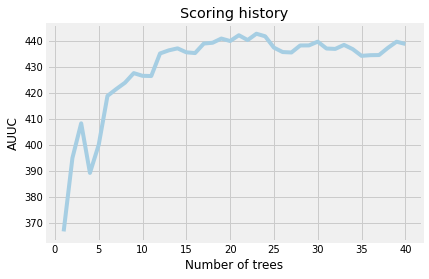

In [9]:
sh = h2o_uplift_model.scoring_history()

import matplotlib.pyplot as plt

plt.plot(sh['training_auuc'])
plt.xlabel('Number of trees')
plt.ylabel('AUUC')
plt.title('Scoring history')
plt.show()


In [10]:
test_h2o = h2o.H2OFrame(test_df)
test_h2o[treatment_column] = test_h2o[treatment_column].asfactor()
test_h2o[response_column] = test_h2o[response_column].asfactor()
preds_h2o = h2o_uplift_model.predict(test_h2o)

perf_h2o = h2o_uplift_model.model_performance(test_h2o)
auuc_h2o = perf_h2o.auuc()
print("H2O training metrics AUUC Gain: "+str(auuc_h2o))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf prediction progress: |█████████████████████████████████████████████████| (done) 100%
H2O training metrics AUUC Gain: 450.7117786374067


In [11]:
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(test_df[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(test_df[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
results = results[["h2o", "causal", response_column, treatment_column]]
mapping = {'control': 0, 'treatment': 1}
results = results.replace({treatment_column: mapping})


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,h2o,causal,diff,treatment,outcome
type,real,real,real,enum,int
mins,-0.6264740526676178,-0.390655875,0.004659703913163948,,0.0
mean,0.08199791085882721,-0.29422592594120467,0.3900188090139431,,0.7579325483935342
maxs,0.4822891443967819,-0.03872682500000013,0.7961030723154424,,1.0
sigma,0.13776629982556876,0.0500373229456983,0.09240175231909001,,0.4283776621130897
zeros,0,0,0,,1213
missing,0,708,708,0,0
0,-0.09308872148394576,-0.3457214499999999,0.2526327285160541,treatment,0.0
1,0.056703162193298295,-0.34273535,0.3994385121932983,treatment,1.0
2,0.07776566892862324,-0.34762824999999997,0.4253939189286232,control,0.0


min: nan max: nan mean: 0.390019


In [12]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
449.1073405919903
CauslML AUUC:
258.7092568544478
Random AUUC:
234.98047847365325


In [13]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=True)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
0.9232925077480227
CauslML AUUC:
0.5318646500498337
Random AUUC:
0.4830820955983254


## Qini

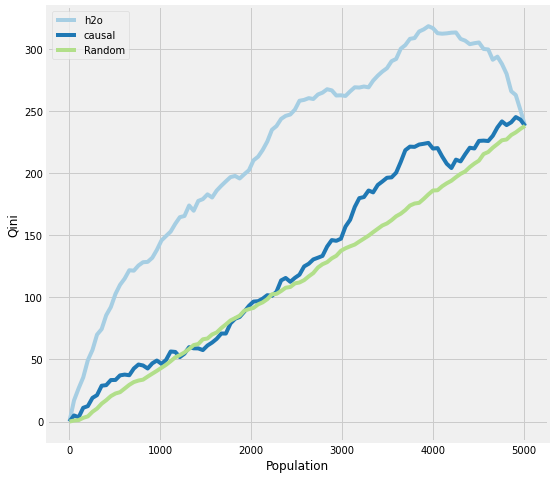

In [14]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)

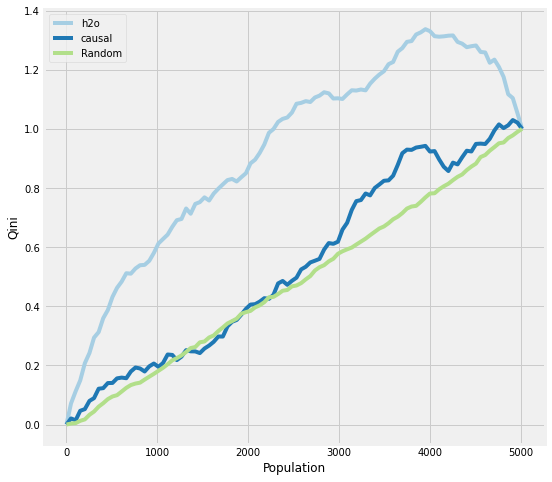

In [15]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column, normalize=True)

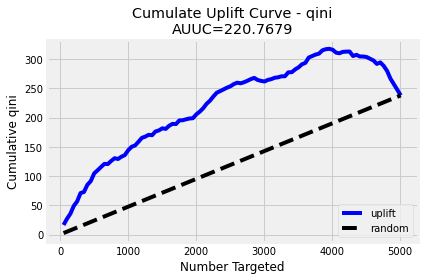

98
[51, 101, 151, 201, 251, 301, 351, 401, 451, 502, 552, 602, 652, 702, 752, 802, 852, 902, 952, 1003, 1053, 1103, 1153, 1203, 1253, 1303, 1353, 1403, 1453, 1504, 1554, 1604, 1654, 1704, 1754, 1804, 1854, 1904, 1954, 2006, 2055, 2105, 2155, 2205, 2255, 2305, 2355, 2405, 2455, 2506, 2556, 2606, 2656, 2706, 2756, 2806, 2856, 2906, 2956, 3007, 3057, 3107, 3157, 3207, 3257, 3307, 3357, 3409, 3457, 3508, 3558, 3608, 3658, 3708, 3758, 3808, 3858, 3908, 3958, 4009, 4060, 4109, 4159, 4209, 4259, 4309, 4359, 4409, 4459, 4510, 4560, 4610, 4660, 4710, 4760, 4810, 4860, 5011]
[16.307692307692307, 26.789473684210527, 35.45977011494253, 48.77272727272727, 56.68840579710145, 70.86956521739131, 72.77720207253886, 84.94883720930233, 91.28688524590164, 104.62172284644194, 109.89795918367348, 115.4447949526814, 120.83529411764707, 120.48517520215634, 125.9090909090909, 130.49289099526067, 129.16071428571428, 133.04621848739495, 135.82258064516128, 144.30710172744722, 150.06557377049182, 152.360281195079

In [16]:
perf_h2o.plot_uplift(metric="qini")

n, uplift = perf_h2o.plot_uplift(metric="qini", plot=False)
print(len(n))
print(n)
print(uplift)

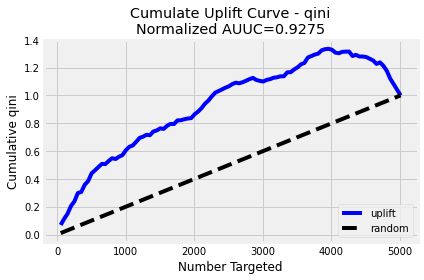

In [17]:
perf_h2o.plot_uplift(metric="qini", normalize=True)

## Lift

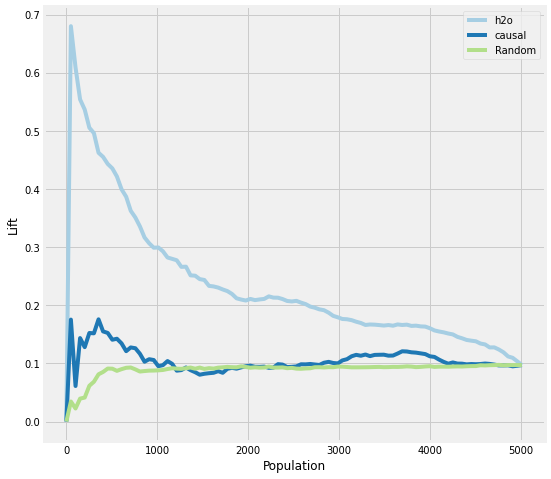

In [18]:
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)

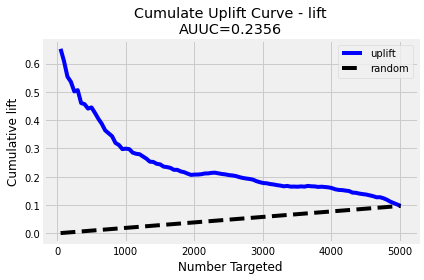

[51, 101, 151, 201, 251, 301, 351, 401, 451, 502, 552, 602, 652, 702, 752, 802, 852, 902, 952, 1003, 1053, 1103, 1153, 1203, 1253, 1303, 1353, 1403, 1453, 1504, 1554, 1604, 1654, 1704, 1754, 1804, 1854, 1904, 1954, 2006, 2055, 2105, 2155, 2205, 2255, 2305, 2355, 2405, 2455, 2506, 2556, 2606, 2656, 2706, 2756, 2806, 2856, 2906, 2956, 3007, 3057, 3107, 3157, 3207, 3257, 3307, 3357, 3409, 3457, 3508, 3558, 3608, 3658, 3708, 3758, 3808, 3858, 3908, 3958, 4009, 4060, 4109, 4159, 4209, 4259, 4309, 4359, 4409, 4459, 4510, 4560, 4610, 4660, 4710, 4760, 4810, 4860, 5011]
[0.6523076923076923, 0.6088516746411483, 0.554058908045977, 0.5359640359640359, 0.5016673079389509, 0.5062111801242236, 0.46061520299075226, 0.45671417854463614, 0.4409994456323751, 0.4451988206231572, 0.4259610821072615, 0.40506945597432065, 0.38729260935143284, 0.3640035504596868, 0.3536772216547498, 0.34340234472437015, 0.3197047383309759, 0.3123150668718191, 0.29785653650254673, 0.2993923272353677, 0.29774915430653137, 0.28

In [19]:
perf_h2o.plot_uplift(metric="lift")

n, uplift = perf_h2o.plot_uplift(metric="lift", plot=False)
print(n)
print(uplift)

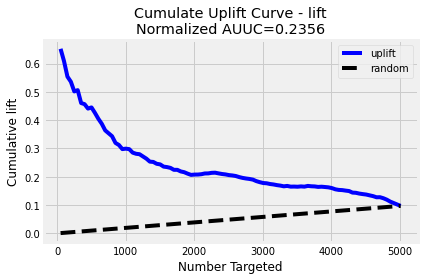

In [20]:
perf_h2o.plot_uplift(metric="lift", normalize=True)

## Gain

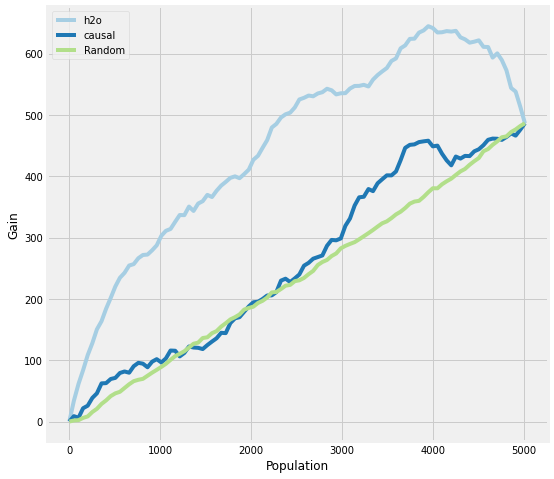

In [21]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

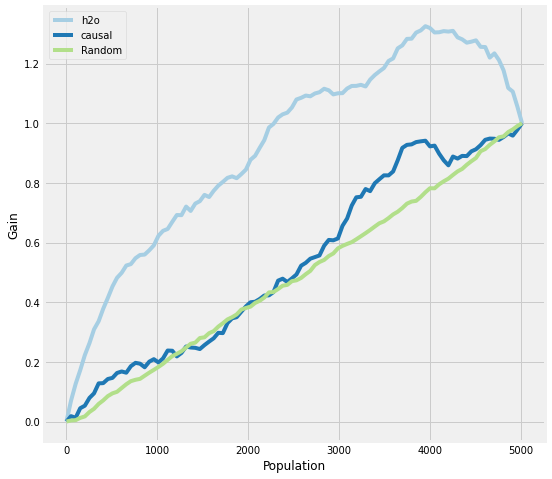

In [22]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column, normalize=True)

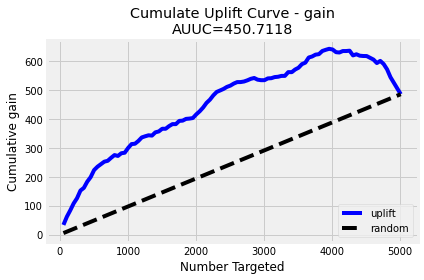

[51, 101, 151, 201, 251, 301, 351, 401, 451, 502, 552, 602, 652, 702, 752, 802, 852, 902, 952, 1003, 1053, 1103, 1153, 1203, 1253, 1303, 1353, 1403, 1453, 1504, 1554, 1604, 1654, 1704, 1754, 1804, 1854, 1904, 1954, 2006, 2055, 2105, 2155, 2205, 2255, 2305, 2355, 2405, 2455, 2506, 2556, 2606, 2656, 2706, 2756, 2806, 2856, 2906, 2956, 3007, 3057, 3107, 3157, 3207, 3257, 3307, 3357, 3409, 3457, 3508, 3558, 3608, 3658, 3708, 3758, 3808, 3858, 3908, 3958, 4009, 4060, 4109, 4159, 4209, 4259, 4309, 4359, 4409, 4459, 4510, 4560, 4610, 4660, 4710, 4760, 4810, 4860, 5011]
[33.26769230769231, 61.49401913875598, 83.66289511494253, 107.72877122877121, 125.91849429267667, 152.3695652173913, 161.67593624975405, 183.1423855963991, 198.89074998020115, 223.48980795282492, 235.13051732320835, 243.85181249654102, 252.51478129713422, 255.53049242270012, 265.96527068437183, 275.40868046894485, 272.3884370579915, 281.70819031838084, 283.55942275042446, 300.29050421707376, 313.52985948477755, 314.706723142644

In [23]:
perf_h2o.plot_uplift(metric="gain")

n, uplift = perf_h2o.plot_uplift(metric="gain", plot=False)
print(n)
print(uplift)

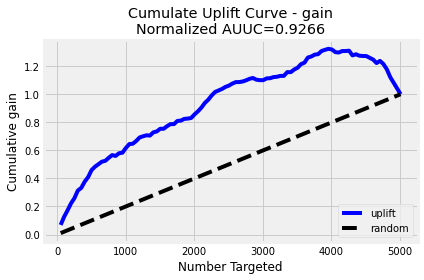

In [24]:
perf_h2o.plot_uplift(metric="gain", normalize=True)